In [41]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import torch

from dqn import DQNAgent

In [21]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
LR = 1e-4
TAU=0.005
EPOCHS = 500

env = gym.make('CartPole-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
agent = DQNAgent(env=env, batch_size=BATCH_SIZE, gamma=GAMMA, eps_start=EPS_START, eps_end=EPS_END, 
                 eps_decay=EPS_DECAY, tau=TAU, lr=LR, device=device, memory_size=10000)

In [23]:
agent.train(EPOCHS)

 88%|████████████████████████████████████████████████████       | 441/500 [1:26:55<25:45, 26.20s/it]

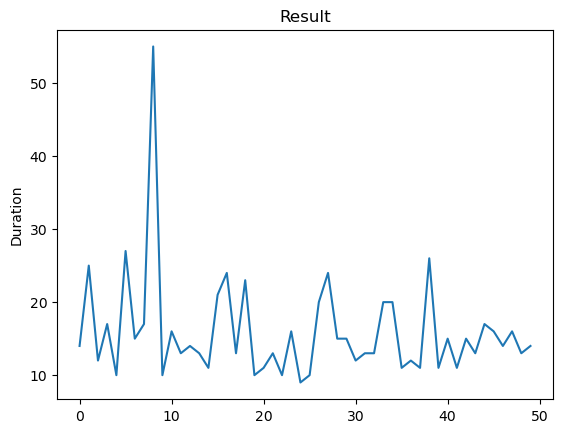

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [42]:
agent.plot_duration(show_result=True)